In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from sklearn.utils import shuffle
from torch.nn import Transformer
import pickle
from torch.nn import functional as F

#plotting 
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

In [2]:
%run ../utils/trials_v04a.py 

In [3]:
%run ../utils/results_explore.py

<Figure size 640x480 with 0 Axes>

In [4]:
#############################################
#############  Experiment Parameters
members_number = 6#5
classes_number = 5#7
same_label_trials = True
############################################# 

filter_condition = ""
if same_label_trials:
    filter_condition = "filt"
else:
    filter_condition = "unfilt"

experiment_name = f"prob_agent_v04_m{members_number}_c{classes_number}_{filter_condition}"
folder_path = f"salidas/{experiment_name}/"

In [5]:
experiment_name

'prob_agent_v04_m6_c5_filt'

In [6]:
members_stim, class_stim, stimuli_set, dummy_set = get_stimuli_list(members_n = members_number, classes_n = classes_number)

In [7]:
protocols_dict = {f"{ts}_{relation}": {'train_structure': ts, 'relation_type': relation} 
                  for ts in ["LS", "OTM", "MTO"] for relation in [
                      'select_reject',
                      'select_only', 
                      'reject_only', 
                  ]}
protocol_names=list(protocols_dict.keys())
protocol_names

['LS_select_reject',
 'LS_select_only',
 'LS_reject_only',
 'OTM_select_reject',
 'OTM_select_only',
 'OTM_reject_only',
 'MTO_select_reject',
 'MTO_select_only',
 'MTO_reject_only']

In [8]:
# for prt_nm in protocol_names:
#     print(prt_nm)
#     protocol = protocols_dict[prt_nm]

#     ###6
#     member_pairs_df = create_pair_members(members_stim, train_structure = protocol["train_structure"])
#     experimental_pairs = create_pairs_classes(member_pairs_df, class_stim)
    
#     baseline_train_trials_info = create_trials(
#         subset_to_trials = "baseline", 
#         pairs_dataset_df = experimental_pairs, 
#         stimuli_list = stimuli_set, 
#         dummy_list = dummy_set, 
#         relation_type = protocol['relation_type'],
#         same_label_filter = same_label_trials
#     )
    
#     reflexivity_trials_info = create_trials(
#         subset_to_trials = "reflexivity", 
#         pairs_dataset_df = experimental_pairs, 
#         stimuli_list = stimuli_set, 
#         dummy_list = dummy_set, 
#         relation_type = "select_reject",
#         same_label_filter = same_label_trials
#     )
    
#     symmetry_trials_info = create_trials(
#         subset_to_trials = "symmetry", 
#         pairs_dataset_df = experimental_pairs, 
#         stimuli_list = stimuli_set, 
#         dummy_list = dummy_set, 
#         relation_type = "select_reject",
#         same_label_filter = same_label_trials
#     )
    
#     transitivity_trials_info = create_trials(
#         subset_to_trials = "transitivity", 
#         pairs_dataset_df = experimental_pairs, 
#         stimuli_list = stimuli_set, 
#         dummy_list = dummy_set, 
#         relation_type = "select_reject",
#         same_label_filter = same_label_trials
#     )
#     ###7
#     comp1_df = pd.DataFrame({
#         'st_sample':baseline_train_trials_info.st_sample,
#         'st_comparison':baseline_train_trials_info.st_comp1,
#         'probability':(baseline_train_trials_info.st_comp1 == baseline_train_trials_info.st_comparison)*1.,
#                  })
#     comp2_df = pd.DataFrame({
#         'st_sample':baseline_train_trials_info.st_sample,
#         'st_comparison':baseline_train_trials_info.st_comp2,
#         'probability':(baseline_train_trials_info.st_comp2 == baseline_train_trials_info.st_comparison)*1.,
#                  })
    
#     comp3_df = pd.DataFrame({
#         'st_sample':baseline_train_trials_info.st_sample,
#         'st_comparison':baseline_train_trials_info.st_comp3,
#         'probability':(baseline_train_trials_info.st_comp3 == baseline_train_trials_info.st_comparison)*1.,
#                  })
    
#     trials_probs_df = pd.concat([comp1_df, comp2_df, comp3_df], axis = 0, ignore_index=True)
#     ###8
#     baseline_probs_df = trials_probs_df.groupby(['st_sample','st_comparison']).mean('probability')
#     baseline_probs_df.reset_index(inplace=True)
#     ###9
#     sorted_labels = ["".join([mbr, clss]) for clss in class_stim for mbr in members_stim ] # for plotting
#     sorted_stimuli = sorted_labels+dummy_set
#     ###10
#     init_probabs = rng.normal(loc=0.5, scale=.01, size=(len(sorted_stimuli),len(sorted_stimuli)))
#     pairs_probs_df = pd.DataFrame(init_probabs, index=sorted_stimuli, columns=sorted_stimuli)
    
#     select_pairs = experimental_pairs[experimental_pairs.pair_subset == "baseline"]
    
#     for index, row in baseline_probs_df.iterrows():
#         pairs_probs_df.loc[row['st_sample'], row['st_comparison']] = row['probability']
#     ###11

#     ###12
#     ###13
#     full_trials=pd.concat([
#         baseline_train_trials_info,
#         reflexivity_trials_info,
#         symmetry_trials_info,
#         transitivity_trials_info,
#     ],ignore_index=True)
#     trials_info_columns=["st_sample","st_comp1","st_comp2","st_comp3","option_answer"]#"st_comparison"
#     ###14
#     sample_list_full_trials = full_trials.st_sample.unique()
#     comparison_list_full_trials = full_trials[["st_comp1","st_comp2","st_comp3"]].melt().value.unique()
#     ###15
#     for comparison_column in trials_info_columns[1:4]:
#         for sample_stim in sample_list_full_trials:
#             comparison_list_full_trials = full_trials[comparison_column].unique()
#             for comparison_stim in comparison_list_full_trials:
#                 full_trials.loc[
#                 (full_trials.st_sample == sample_stim) & (full_trials[comparison_column] == comparison_stim),
#                 comparison_column+"_prob"
#                 ] = pairs_probs_df.loc[sample_stim, comparison_stim]
#     ###16
#     full_trials["response"] = full_trials[['st_comp1_prob','st_comp2_prob','st_comp3_prob']].idxmax(axis=1)
#     ###17
#     full_trials["response"] = full_trials["response"].replace(['st_comp1_prob','st_comp2_prob','st_comp3_prob'], ['O_1','O_2','O_3'])
#     ###18
#     full_trials["response_score"] = (full_trials["response"]==full_trials["option_answer"])*1
#     full_trials['sample_member']=[stim[0] for stim in full_trials.st_sample]
#     full_trials['comparison_member']=[stim[0] for stim in full_trials.st_comparison]
    
#     protocol_output = full_trials
#     ###19
#     random_limit = .37
    
#     protocol_output.loc[protocol_output.sample_subset=="baseline", "sample_subset"]="train"
#     evaluation_graph_dat = get_agent_graph_dat(
#         agent_info_df = protocol_output, 
#         metric_column = "response_score"
#     )
#     evaluation_graph_dat.response_score = evaluation_graph_dat.response_score.astype("float")
    
#     fig, all_axes = plt.subplots(1, 2, figsize=(18, 8))
#     axs = all_axes.flat
    
#     fig.suptitle(f"Probabilities Agent's Performance on {
# protocols_dict[prt_nm]['train_structure']} training with {
# (protocols_dict[prt_nm]['relation_type']).replace("_", " ") } relations {
# filter_condition}")
    
#     heatmap_out=plot_heatmap_dat(
#         graph_dat_plot=evaluation_graph_dat, 
#         metric_column="response_score", 
#         minimal_cut_value=.9,
#         random_level=random_limit,
#         ax_plot = axs[0]
#     )
    
#     plot_graph_results(
#         graph_dat_plot=evaluation_graph_dat,
#         metric_column="response_score",
#         node_origin="sample_member",
#         node_destiny="comparison_member",
#         trial_group="sample_subset",
#         minimal_cut_value=.9,
#         random_level=random_limit,
#         ax_plot = axs[1]
#     )
#     plt.show()

#     ###SAVE Plot
#     # fig.savefig(folder_path+prt_nm+".pdf")
#     #### Save protocol output
#     # full_trials.to_pickle(folder_path+prt_nm+".pkl")


In [9]:
# Stop!!

In [10]:
protocol_names

['LS_select_reject',
 'LS_select_only',
 'LS_reject_only',
 'OTM_select_reject',
 'OTM_select_only',
 'OTM_reject_only',
 'MTO_select_reject',
 'MTO_select_only',
 'MTO_reject_only']

In [29]:
baseline_same_label_filter = False
evaluation_same_label_filter = True

In [47]:
prt_nm = protocol_names[1]#  0 3 6 

print(prt_nm)
protocol = protocols_dict[prt_nm]
member_pairs_df = create_pair_members(members_stim, train_structure = protocol["train_structure"])
experimental_pairs = create_pairs_classes(member_pairs_df, class_stim)

LS_select_only


In [48]:

reflexivity_trials_info = create_trials(
    subset_to_trials = "reflexivity", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = "select_reject",
    same_label_filter = same_label_trials
)

symmetry_trials_info = create_trials(
    subset_to_trials = "symmetry", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = "select_reject",
    same_label_filter = same_label_trials
)

transitivity_trials_info = create_trials(
    subset_to_trials = "transitivity", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = "select_reject",
    same_label_filter = same_label_trials
)

In [49]:
baseline_train_trials_info = create_trials(
    subset_to_trials = "baseline", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = protocol['relation_type'],
    same_label_filter = same_label_trials
)

Probabilities agent
- Previously established 3-term contingencies B1-Response-Reinforcer(reward)
- Matrix of probabilities of getting a reinforcer by selecting a specific comparison (a 3-term contingency which comparison acts as discriminative stimulus) given a sample (a conditional stimulus that controls a 3-term contingency). 
$$ P_{reinforcer}\left(Comparison\vert Sample \right)$$
- Initialize matrix, i.e. $P_{reinforcer}\left(B1 \vert A1 \right) = 0.5$ with random normal noise ($scale = .01$)
- In a trial, agent selects the pair with the highest probability of reinforcer.

In [50]:
# ### Sequential Train baseline pairs.

# BA_pairs = baseline_train_trials_info[(
#     baseline_train_trials_info["st_sample"].str.contains("B"))&(
#         baseline_train_trials_info["st_comparison"].str.contains("A")
#     )
# ]

# CA_pairs = baseline_train_trials_info[(
#     baseline_train_trials_info["st_sample"].str.contains("C"))&(
#         baseline_train_trials_info["st_comparison"].str.contains("A")
#     )
# ]

# DA_pairs = baseline_train_trials_info[(
#     baseline_train_trials_info["st_sample"].str.contains("D"))&(
#         baseline_train_trials_info["st_comparison"].str.contains("A")
#     )
# ]

# EA_pairs = baseline_train_trials_info[(
#     baseline_train_trials_info["st_sample"].str.contains("E"))&(
#         baseline_train_trials_info["st_comparison"].str.contains("A")
#     )
# ]

# FA_pairs = baseline_train_trials_info[(
#     baseline_train_trials_info["st_sample"].str.contains("F"))&(
#         baseline_train_trials_info["st_comparison"].str.contains("A")
#     )
# ]

# baseline_train_trials_info = pd.concat([BA_pairs, 
#                                         CA_pairs, 
#                                         DA_pairs, 
#                                         EA_pairs
#                                        ], axis = 0)

In [51]:
##### Reflexivity and baseline training

# baseline_train_trials_info = pd.concat([baseline_train_trials_info, 
#                                         reflexivity_trials_info, 
#                                         symmetry_trials_info, 
#                                        ], axis = 0)

In [52]:
comp1_df = pd.DataFrame({
    'st_sample':baseline_train_trials_info.st_sample,
    'st_comparison':baseline_train_trials_info.st_comp1,
    'probability':(baseline_train_trials_info.st_comp1 == baseline_train_trials_info.st_comparison)*1.,
             })
comp2_df = pd.DataFrame({
    'st_sample':baseline_train_trials_info.st_sample,
    'st_comparison':baseline_train_trials_info.st_comp2,
    'probability':(baseline_train_trials_info.st_comp2 == baseline_train_trials_info.st_comparison)*1.,
             })

comp3_df = pd.DataFrame({
    'st_sample':baseline_train_trials_info.st_sample,
    'st_comparison':baseline_train_trials_info.st_comp3,
    'probability':(baseline_train_trials_info.st_comp3 == baseline_train_trials_info.st_comparison)*1.,
             })

trials_probs_df = pd.concat([comp1_df, comp2_df, comp3_df], axis = 0, ignore_index=True)

In [53]:
baseline_probs_df = trials_probs_df.groupby(['st_sample','st_comparison']).mean('probability')
baseline_probs_df.reset_index(inplace=True)

In [54]:
sorted_labels = ["".join([mbr, clss]) for clss in class_stim for mbr in members_stim ] # for plotting
sorted_stimuli = sorted_labels+dummy_set

In [55]:
init_probabs = rng.normal(loc=0.5, scale=.01, size=(len(sorted_stimuli),len(sorted_stimuli)))
pairs_probs_df = pd.DataFrame(init_probabs, index=sorted_stimuli, columns=sorted_stimuli)

select_pairs = experimental_pairs[experimental_pairs.pair_subset == "baseline"]

for index, row in baseline_probs_df.iterrows():
    pairs_probs_df.loc[row['st_sample'], row['st_comparison']] = row['probability']

Text(0.5, 1.0, 'Reinforcer Probabilities on LS training with select only relations filt')

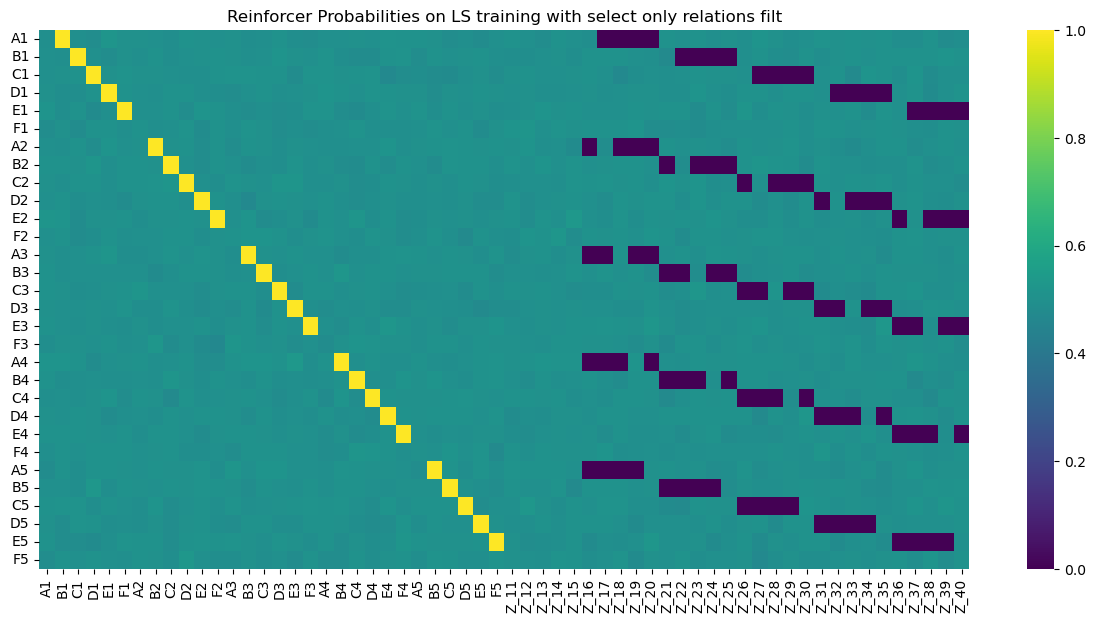

In [56]:
plt.figure(figsize=(15,7))
sns.heatmap(pairs_probs_df.loc[sorted_labels,], vmin=0, vmax=1, cmap = "viridis")
plt.title(f"Reinforcer Probabilities on {
protocols_dict[prt_nm]['train_structure']} training with {
(protocols_dict[prt_nm]['relation_type']).replace("_", " ") } relations {
filter_condition}")


In [57]:
full_trials=pd.concat([
    baseline_train_trials_info,
    reflexivity_trials_info,
    symmetry_trials_info,
    transitivity_trials_info,
],ignore_index=True)
trials_info_columns=["st_sample","st_comp1","st_comp2","st_comp3","option_answer"]#"st_comparison"

In [58]:
sample_list_full_trials = full_trials.st_sample.unique()
comparison_list_full_trials = full_trials[["st_comp1","st_comp2","st_comp3"]].melt().value.unique()

In [59]:
for comparison_column in trials_info_columns[1:4]:
    for sample_stim in sample_list_full_trials:
        comparison_list_full_trials = full_trials[comparison_column].unique()
        for comparison_stim in comparison_list_full_trials:
            full_trials.loc[
            (full_trials.st_sample == sample_stim) & (full_trials[comparison_column] == comparison_stim),
            comparison_column+"_prob"
            ] = pairs_probs_df.loc[sample_stim, comparison_stim]

In [60]:
full_trials["response"] = full_trials[['st_comp1_prob','st_comp2_prob','st_comp3_prob']].idxmax(axis=1)

In [61]:
full_trials["response"] = full_trials["response"].replace(['st_comp1_prob','st_comp2_prob','st_comp3_prob'], ['O_1','O_2','O_3'])

In [62]:
full_trials["response_score"] = (full_trials["response"]==full_trials["option_answer"])*1

full_trials['sample_member']=[stim[0] for stim in full_trials.st_sample]
full_trials['comparison_member']=[stim[0] for stim in full_trials.st_comparison]

protocol_output = full_trials

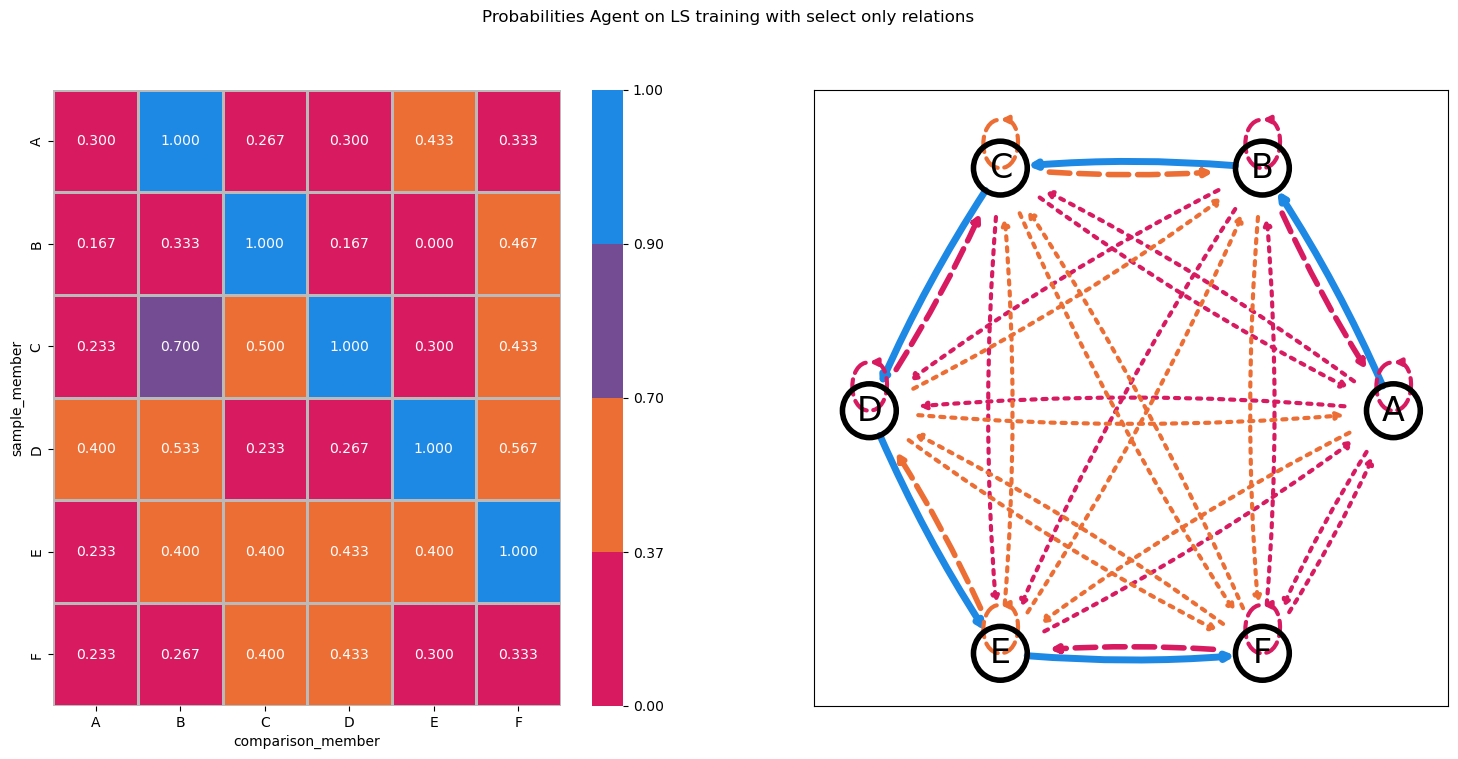

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [63]:
random_limit = .37

protocol_output.loc[protocol_output.sample_subset=="baseline", "sample_subset"]="train"
evaluation_graph_dat = get_agent_graph_dat(
    agent_info_df = protocol_output, 
    metric_column = "response_score"
)
evaluation_graph_dat.response_score = evaluation_graph_dat.response_score.astype("float")

fig, all_axes = plt.subplots(1, 2, figsize=(18, 8))
axs = all_axes.flat

fig.suptitle(' '.join([
    "Probabilities Agent on",
    protocols_dict[prt_nm]['train_structure'], "training with", 
    (protocols_dict[prt_nm]['relation_type']).replace("_", " "), "relations",
    # filter_condition
]))
heatmap_out=plot_heatmap_dat(
    graph_dat_plot=evaluation_graph_dat, 
    metric_column="response_score", 
    minimal_cut_value=.9,
    random_level=random_limit,
    ax_plot = axs[0]
)

plot_graph_results(
    graph_dat_plot=evaluation_graph_dat,
    metric_column="response_score",
    node_origin="sample_member",
    node_destiny="comparison_member",
    trial_group="sample_subset",
    minimal_cut_value=.9,
    random_level=random_limit,
    ax_plot = axs[1]
)

### SAVE Plot
# fig.savefig("salidas/"+experiment_name+"_output_embedded.pdf")